In [1]:
import os
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import STForte.helper as stfhelper
import matplotlib.patches as mpatches
from STForte.helper import mclust_R
from STForte.helper import save_gdata
from paste2 import PASTE2, projection
from STForte import STGraph, STForteModel
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

trial_name = "trial-DLPFC-pca-151673"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
palette=stfhelper.pl.prism_2000s_palette

Global seed set to 0


## Preprocessing and Data alignment
STGraph provide initialization method from multiple slieds (STGraph.GraphFrom3DAnndata) if the 3D coordinates or the within tissue distances are known. If only consecutive tissue sections are provided, STForte requires section alignment using PASTE2 and construct the spatial graph in 2D settings.

In [2]:
data_list = ["151507","151508","151509","151510"]
adata = []
for data in data_list:
    adata.append(
        sc.read_h5ad(f"/home/wcx99075523/Experiments/STForte/data/DLPFC/{data}_10xvisium.h5ad")
    )

In [3]:
pis = []
for i in range(3):
    pis.append(PASTE2.partial_pairwise_align(adata[i], adata[i+1], s=0.7))

PASTE2 starts...
Starting GLM-PCA...
Iteration: 0 | deviance=1.6010E+7
Iteration: 1 | deviance=1.6010E+7
Iteration: 2 | deviance=1.5189E+7
Iteration: 3 | deviance=1.4790E+7
Iteration: 4 | deviance=1.4607E+7
Iteration: 5 | deviance=1.4520E+7
Iteration: 6 | deviance=1.4472E+7
Iteration: 7 | deviance=1.4442E+7
Iteration: 8 | deviance=1.4421E+7
Iteration: 9 | deviance=1.4404E+7
Iteration: 10 | deviance=1.4391E+7
Iteration: 11 | deviance=1.4381E+7
Iteration: 12 | deviance=1.4371E+7
Iteration: 13 | deviance=1.4363E+7
Iteration: 14 | deviance=1.4356E+7
Iteration: 15 | deviance=1.4350E+7
Iteration: 16 | deviance=1.4344E+7
Iteration: 17 | deviance=1.4339E+7
Iteration: 18 | deviance=1.4334E+7
Iteration: 19 | deviance=1.4330E+7
Iteration: 20 | deviance=1.4326E+7
Iteration: 21 | deviance=1.4322E+7
Iteration: 22 | deviance=1.4319E+7
Iteration: 23 | deviance=1.4316E+7
Iteration: 24 | deviance=1.4313E+7
Iteration: 25 | deviance=1.4311E+7
Iteration: 26 | deviance=1.4308E+7
Iteration: 27 | deviance=1.4

In [4]:
new_slices = projection.partial_stack_slices_pairwise(adata, pis)

In [6]:
adata_cat = sc.concat(new_slices,axis=0)
adata_cat

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 18033 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD'
    obsm: 'spatial'

In [7]:
for i in range(4):
    adata_cat.uns[data_list[i]] = new_slices[i].uns
adata_cat.obs['section_id'] = np.array([0]*4226+[1]*4384+[2]*4789+[3]*4634)
adata_cat

AnnData object with n_obs × n_vars = 18033 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'section_id'
    uns: '151507', '151508', '151509', '151510'
    obsm: 'spatial'

In [8]:
adata_cat.write("/home/wcx99075523/PublishedPackages/STForte_v1/tutorials/trial-DLPFC-pca-151673/data/adata_673_676_paste2.h5ad")

## Data loading and model setup

In [2]:
adata = sc.read_h5ad(filename="/home/wcx99075523/PublishedPackages/STForte_v1/trial-DLPFC-pca/multi_slides/data/adata_673_676_paste2.h5ad")
adata.obs['section_id'] = adata.obs['section_id'].astype("str").astype("category")
adata

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 14364 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'section_id'
    uns: '151673', '151674', '151675', '151676'
    obsm: 'spatial'

In [3]:
adata.layers["log1p"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4, layer="log1p")
sc.pp.log1p(adata, layer="log1p")
adata = adata[:,adata.X.sum(axis=0)!=0]
adata

View of AnnData object with n_obs × n_vars = 14364 × 24155
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'section_id'
    uns: '151673', '151674', '151675', '151676', 'log1p'
    obsm: 'spatial'
    layers: 'log1p'

In [4]:
d = adata.uns[list(adata.uns.keys())[0]]['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d = d 
)
stgraph.pca(n_components=300,svd_solver="full")
gdata = stgraph.topyg()

/home/wcx99075523/PublishedPackages/STForte_v1/tutorials/../STForte/_data.py:96: UserWarning: 'obs_name' not unique. Please run 'adata.obs_names_make_unique' at first for index security.
  warnings.warn("'obs_name' not unique. Please run 'adata.obs_names_make_unique' at first for index security.")


d-based initialize:   0%|          | 0/14364 [00:00<?, ?it/s]

PCA pre-compression for data, from 24155 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 521.78s.


In [5]:
model = STForteModel(adata=adata, gdata=gdata, epochs=550,
                     output_dir='./{:s}/pl_ckpts/'.format(trial_name),
                     module_kwargs=dict(
                        partial_adjacent=True, lmbd_cross=10, lmbd_gan=4,
                        ),
                     )
model.fit()

Global seed set to 42
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_a00c41 | 71.9 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K    

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=550` reached.


In [6]:
if not os.path.exists(f"{trial_name}/data"):
    os.makedirs(f"{trial_name}/data")   
save_gdata(gdata, path=f"{trial_name}/data/gdata_multi.pkl")
adata.write_h5ad(f"{trial_name}/data/trial_multi.h5ad")

In [7]:
import torch
z_attr, z_strc, _, _, _, _ = model._get_module_output()
adata.obsm['STForte_ATTR'] = z_attr.detach().numpy()
adata.obsm['STForte_TOPO'] = z_strc.detach().numpy()
adata.obsm['STForte_COMB'] = torch.cat([z_attr,z_strc],dim=1).detach().numpy()
if not os.path.exists(f"./{trial_name}/outputs"):
    os.makedirs(f"./{trial_name}/outputs")
adata.write(f"./{trial_name}/outputs/stforte_multi.h5ad")

/tmp/ipykernel_61823/12540644.py:3: ImplicitModificationWarning: Setting element `.obsm['STForte_ATTR']` of view, initializing view as actual.
  adata.obsm['STForte_ATTR'] = z_attr.detach().numpy()
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
n_clusters = 7
for emb in ['STForte_ATTR', 'STForte_COMB', 'STForte_TOPO']:
    sc.pp.neighbors(adata, use_rep=f"{emb}")
    adata.obsm[f"X_UMAP_{emb}"] = sc.tl.umap(adata, copy=True).obsm['X_umap']
    mclust_R(adata, n_clusters, obs_add=f"mclust_{emb}", used_obsm=emb)
    adata.obs[f"mclust_{emb}"] = adata.obs[f"mclust_{emb}"].apply(lambda x: f"C{x}").astype("category")
sc.pp.neighbors(adata)
adata.obsm['UMAP_before'] = sc.tl.umap(adata, copy=True).obsm['X_umap']
adata

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 14364 × 24155
    obs: 'in_tissue', 'array_row', 'array_col', 'spatialLIBD', 'section_id', 'mclust_STForte_ATTR', 'mclust_STForte_COMB', 'mclust_STForte_TOPO'
    uns: '151673', '151674', '151675', '151676', 'log1p', 'neighbors'
    obsm: 'spatial', 'STForte_ATTR', 'STForte_TOPO', 'STForte_COMB', 'X_UMAP_STForte_ATTR', 'X_UMAP_STForte_COMB', 'X_UMAP_STForte_TOPO', 'X_pca', 'UMAP_before'
    layers: 'log1p'
    obsp: 'distances', 'connectivities'

<Axes: title={'center': 'mclust STForte TOPO'}>

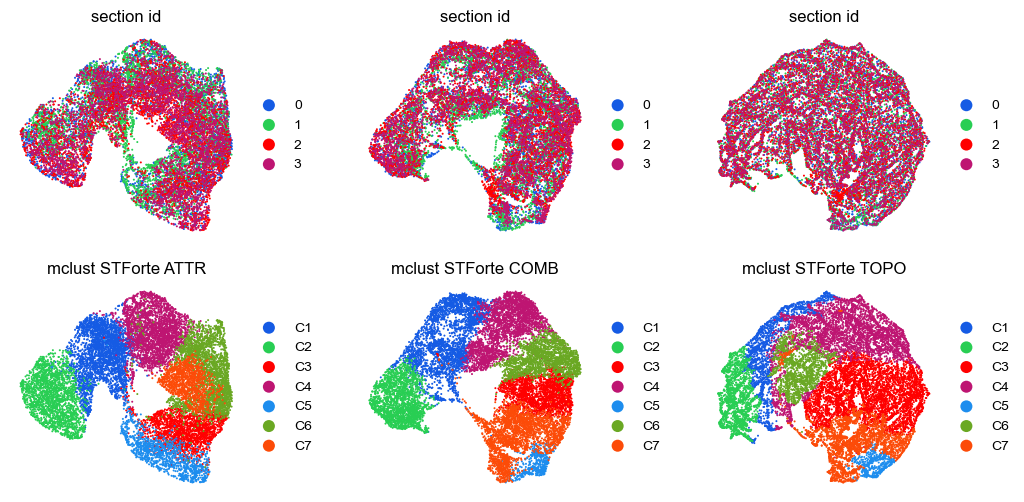

In [9]:
ncols, nrows = 3, 2
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.scatter(adata, color="section_id", basis=f"UMAP_STForte_ATTR", frameon=False, palette=palette, show=False, ax=axs[0][0],)   
sc.pl.scatter(adata, color="section_id", basis=f"UMAP_STForte_COMB", frameon=False, palette=palette, show=False, ax=axs[0][1],)   
sc.pl.scatter(adata, color="section_id", basis=f"UMAP_STForte_TOPO", frameon=False, palette=palette, show=False, ax=axs[0][2],)
sc.pl.scatter(adata, color=f"mclust_STForte_ATTR", basis=f"UMAP_STForte_ATTR", frameon=False, palette=palette, show=False, ax=axs[1][0],)   
sc.pl.scatter(adata, color=f"mclust_STForte_COMB", basis=f"UMAP_STForte_COMB", frameon=False, palette=palette, show=False, ax=axs[1][1],)   
sc.pl.scatter(adata, color=f"mclust_STForte_TOPO", basis=f"UMAP_STForte_TOPO", frameon=False, palette=palette, show=False, ax=axs[1][2],)

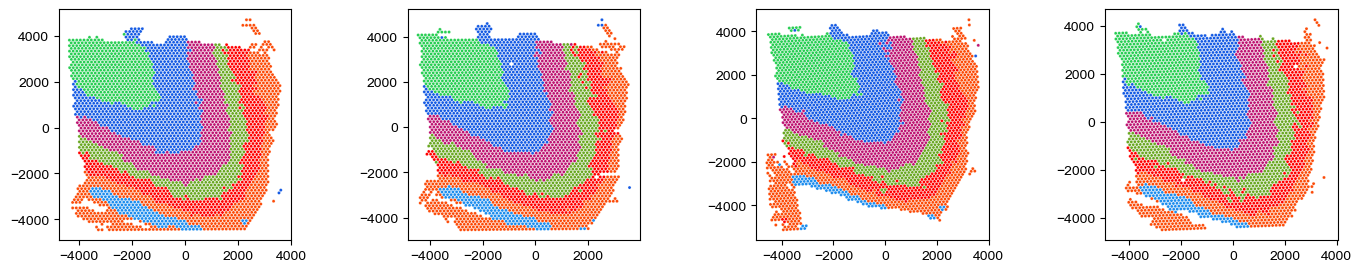

In [10]:
ncols, nrows = 4, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
coord = adata.obsm["spatial"]
label_sub = adata.obs["mclust_STForte_COMB"]
palette=stfhelper.pl.prism_2000s_palette[:7]
i = 0
for ss in adata.obs['section_id'].cat.categories:
    coord_sub = coord[adata.obs["section_id"] == ss]
    stat_sub = label_sub[adata.obs["section_id"] == ss]
    sns.scatterplot(x=coord_sub[:,0],y=coord_sub[:,1],hue=stat_sub,
                    size=np.array([1]*len(coord_sub)),sizes={1:5},
                    palette=palette,ax=axs[i],legend=False)
    
    i += 1

In [11]:
print("ARI_COMB:",ARI(adata.obs['mclust_STForte_COMB'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))
print("NMI_COMB:",NMI(adata.obs['mclust_STForte_COMB'].to_numpy(), adata.obs['spatialLIBD'].astype(str)))

ARI_COMB: 0.5982304710242632
NMI_COMB: 0.6951680713705387
